In [238]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

In [239]:
NUM_ANS = 78
POSSIBLE_ANSWERS = [1,2,3]
participants_to_exclude = [
    "jason fong",
    "Dan test",
    "not applicable",
]

def get_aggregated_answers(csv_path):
    # load data from each test from csvs
    with open(csv_path) as f:
        all_lines = f.readlines()

    # only get the lines referring to specific participants
    lines = [l for l in all_lines if "anonymous,EN" in l]
    
    # exclude some participants
    new_lines = []
    for l in lines:
        exclude_participant = False
        for participant in participants_to_exclude:
            if participant in l:
                exclude_participant = True
                print("excluding", participant)
        if exclude_participant:
            pass
        else:
            new_lines.append(l)
            
    lines = new_lines

    aggregated_answers = defaultdict(Counter) # aggregated over all participants, key is question num, value is dict of answers to answer counts
    """
    aggregated_answers = {
        question1: {
            ans1: count_of_ans1,
            ans2: count_of_ans2,
            ans3: count_of_ans3,
        }, 
        question2: {
            ans1: count_of_ans1,
            ans2: count_of_ans2,
            ans3: count_of_ans3,
        }, 
        ...
    }
    """

    for line in lines:
        # get the answers for each participant
        answers = line.split("anonymous,EN")[-1].split(',')[3:-1] # upto but excluding last element as last question in survey is confirmation of working audio
        answers = [int(ans) for ans in answers]

        # assert that we have the correct number of answers and that they have the correct values
        assert len(answers) == NUM_ANS, len(answers)
        for ans in answers:
            assert ans in POSSIBLE_ANSWERS

        # aggregate the answer for this participant
        for question_num, ans in enumerate(answers, 1):
            aggregated_answers[question_num][ans] += 1
            
    return aggregated_answers

In [240]:
def get_conditions(test_num, utt_num):
    assert 1 <= test_num <= 6
    assert 1 <= utt_num <= NUM_ANS

    # create testnum + uttnum -> pair of conditions -> conditions mapping 
    ranges = [ # range of questions related to each condition pair
        (0,13), # for first condition pair
        (13,26), # for second condition pair
        (26,39), # etc.
        (39,52),
        (52,65),
        (65,78),
    ]

    testnum2conditionpairs = { 
        1: ('A','B','F','C','E','D'), # test num to condition pairs 
        2: ('B','C','A','D','F','E'), 
        3: ('C','D','B','E','A','F'),
        4: ('D','E','C','F','B','A'),
        5: ('E','F','D','A','C','B'),
        6: ('F','A','E','B','D','C'),
    }

    letter2conditionpair = {
        'A': ("sac_grapheme", "vanillatts_grapheme"), # condition pair to system on left and system on right
        'B': ("sac_speechcode_us", "vanillatts_grapheme"),
        'C': ("sac_speechcode_us", "sac_grapheme"),
        'D': ("sac_speechcode_scot", "vanillatts_grapheme"),
        'E': ("sac_speechcode_scot", "sac_grapheme"),
        'F': ("sac_speechcode_scot", "sac_speechcode_us"),
    }

    # get the condition pair
    for condition_pair_idx, r in enumerate(ranges):
        if r[0] < utt_num <= r[1]:
            condition_pair = testnum2conditionpairs[test_num][condition_pair_idx]
            break

    # get the conditions from the condition pair
    cond1, cond2 = letter2conditionpair[condition_pair]
    # print("test_num", test_num, "utt_num", utt_num, "condition_pair", condition_pair,"cond1", cond1, "cond2", cond2)
    
    return cond1, cond2

In [241]:
def get_conditionpair2wincounts(aggregated_answers, test_num):

    conditionpair2wincounts = Counter()
    """
    conditionpair2wincounts = {
        (cond1,cond2): 5, # cond1 beats cond2 5 times
        (cond2,cond1): 50 # cond2 beats cond1 50 times
    }

    NB ties/draws give 0.5 of a win to both conditions
    """
    
    conditionpair2numwins_and_numdraws = defaultdict(Counter)
    """
    conditionpair2numwins_and_numdraws = {
        (cond1,cond2): {
            wins: 20
            draws: 12
        },
        (cond2,cond1): {
            wins: 5
            draws: 4
        } 
        ...
    }
    """
    

    # add wins to systems based on aggregated_answers and the pair of conditions
    for utt_num, answer2counts in aggregated_answers.items():
        # print(utt_num, answer2counts)
        cond1, cond2 = get_conditions(test_num, utt_num)
        if 1 in answer2counts: # cond1 won
            conditionpair2wincounts[(cond1, cond2)] += answer2counts[1]
            conditionpair2numwins_and_numdraws[(cond1, cond2)]['wins'] += answer2counts[1]
        if 2 in answer2counts: # cond2 won
            conditionpair2wincounts[(cond2, cond1)] += answer2counts[2]
            conditionpair2numwins_and_numdraws[(cond2, cond1)]['wins'] += answer2counts[2]
        if 3 in answer2counts: # cond1 and 2 drew
            conditionpair2wincounts[(cond1, cond2)] += 0.5 * answer2counts[3]
            # print("conditionpair2wincounts[(cond1, cond2)]", conditionpair2wincounts[(cond1, cond2)])
            conditionpair2wincounts[(cond2, cond1)] += 0.5 * answer2counts[3]
            conditionpair2numwins_and_numdraws[(cond1, cond2)]['draws'] += answer2counts[3]
            conditionpair2numwins_and_numdraws[(cond2, cond1)]['draws'] += answer2counts[3]

    return conditionpair2wincounts, conditionpair2numwins_and_numdraws

In [242]:
# use testnum + uttnum -> pair of conditions -> conditions mapping 
# to assemble counts of how many times one condition beats another condition
paths = [
    "listening_test_data/IS2022 - Test 1 - Final_March 21, 2022_05.18.csv",
    "listening_test_data/IS2022 - Test 2 - Final_March 21, 2022_05.19.csv",
    "listening_test_data/IS2022 - Test 3 - Final_March 21, 2022_05.19.csv",
    "listening_test_data/IS2022 - Test 4 - Final_March 21, 2022_05.19.csv",
    "listening_test_data/IS2022 - Test 5 - Final_March 21, 2022_05.20.csv",
    "listening_test_data/IS2022 - Test 6 - Final_March 21, 2022_05.20.csv",
]

alltests_conditionpair2wincounts = Counter()
alltests_conditionpair2numwins_and_numdraws = defaultdict(Counter)

for test_num, csv_path in enumerate(paths, 1):
    conditionpair2wincounts, conditionpair2numwins_and_numdraws = get_conditionpair2wincounts(get_aggregated_answers(csv_path), test_num)
    for conditionpair, wincount in conditionpair2wincounts.items():
        # print("DEBUG", test_num, csv_path, conditionpair, wincount)
        alltests_conditionpair2wincounts[conditionpair] += wincount
        
    for conditionpair,numwins_and_numdraws in conditionpair2numwins_and_numdraws.items():
        # print(alltests_conditionpair2wincounts)
        # print(numwins_and_numdraws)
        alltests_conditionpair2numwins_and_numdraws[conditionpair]['wins'] += numwins_and_numdraws['wins']
        alltests_conditionpair2numwins_and_numdraws[conditionpair]['draws'] += numwins_and_numdraws['draws']

excluding jason fong
excluding Dan test
excluding not applicable


In [243]:
alltests_conditionpair2numwins_and_numdraws

defaultdict(collections.Counter,
            {('sac_grapheme',
              'vanillatts_grapheme'): Counter({'wins': 29, 'draws': 156}),
             ('vanillatts_grapheme',
              'sac_grapheme'): Counter({'wins': 36, 'draws': 156}),
             ('sac_speechcode_us',
              'vanillatts_grapheme'): Counter({'wins': 159, 'draws': 29}),
             ('vanillatts_grapheme',
              'sac_speechcode_us'): Counter({'wins': 33, 'draws': 29}),
             ('sac_speechcode_us',
              'sac_speechcode_scot'): Counter({'wins': 92, 'draws': 59}),
             ('sac_speechcode_scot',
              'sac_speechcode_us'): Counter({'wins': 70, 'draws': 59}),
             ('sac_speechcode_us',
              'sac_grapheme'): Counter({'wins': 158, 'draws': 42}),
             ('sac_grapheme',
              'sac_speechcode_us'): Counter({'wins': 21, 'draws': 42}),
             ('sac_speechcode_scot',
              'sac_grapheme'): Counter({'wins': 140, 'draws': 59}),
          

In [244]:
# visualise this counts matrix
alltests_conditionpair2wincounts

Counter({('sac_grapheme', 'vanillatts_grapheme'): 107.0,
         ('vanillatts_grapheme', 'sac_grapheme'): 114.0,
         ('sac_speechcode_us', 'vanillatts_grapheme'): 173.5,
         ('vanillatts_grapheme', 'sac_speechcode_us'): 47.5,
         ('sac_speechcode_us', 'sac_speechcode_scot'): 121.5,
         ('sac_speechcode_scot', 'sac_speechcode_us'): 99.5,
         ('sac_speechcode_us', 'sac_grapheme'): 179.0,
         ('sac_grapheme', 'sac_speechcode_us'): 42.0,
         ('sac_speechcode_scot', 'sac_grapheme'): 169.5,
         ('sac_grapheme', 'sac_speechcode_scot'): 51.5,
         ('sac_speechcode_scot', 'vanillatts_grapheme'): 164.5,
         ('vanillatts_grapheme', 'sac_speechcode_scot'): 56.5})

In [245]:
# save counts matrix in format ready for R and bradley terry analysis (perfmod version of BTL)
c = np.zeros((4,4), dtype=int)

# description from https://github.com/EllaKaye/BradleyTerryScalable
# A matrix (either a base matrix or a class from the Matrix package), dimension K by K, 
# where K is the number of items. The i, j-th element is wi**j, the number of times item i has beaten item j. 
# Ties can be accounted for by assigning half a win (i.e. 0.5) to each item.

In [246]:
c 

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [247]:
cond2matrix_idx = {
    "vanillatts_grapheme": 0,
    "sac_grapheme": 1,
    "sac_speechcode_us": 2,
    "sac_speechcode_scot": 3,
}

In [248]:
for (cond1, cond2), count in alltests_conditionpair2wincounts.items():
    i, j = cond2matrix_idx[cond1], cond2matrix_idx[cond2]
    c[i][j] = count

In [249]:
c

array([[  0, 114,  47,  56],
       [107,   0,  42,  51],
       [173, 179,   0, 121],
       [164, 169,  99,   0]])

In [250]:
# create a pandas dataframe so we can label rows and columns
column_names = ["vanillatts_grapheme", "sac_grapheme", "sac_speechcode_us", "sac_speechcode_scot"]
row_names = ["vanillatts_grapheme", "sac_grapheme", "sac_speechcode_us", "sac_speechcode_scot"]
df = pd.DataFrame(c, columns=column_names, index=row_names)

In [251]:
df

,vanillatts_grapheme,sac_grapheme,sac_speechcode_us,sac_speechcode_scot
vanillatts_grapheme,0,114,47,56
sac_grapheme,107,0,42,51
sac_speechcode_us,173,179,0,121
sac_speechcode_scot,164,169,99,0


In [252]:
np.savetxt("listening_test_data/counts_matrix.txt", c.astype(int), fmt='%i', delimiter=",")

# Use python package choix to get bradley terry estimates of quality for our conditions

In [253]:
from choix import lsr_pairwise_dense, ilsr_pairwise_dense #non iterative and iterative versions

In [254]:
lsr_pairwise_dense(c).tolist()

[-0.5744829439815764,
 -0.6815273954228719,
 0.7343366068119944,
 0.5216737325924541]

In [255]:
islr_res = ilsr_pairwise_dense(c).tolist()
islr_res

[-0.5813515408693363,
 -0.6736261821832774,
 0.7358235742260038,
 0.5191541488266098]

In [256]:
list(zip(islr_res, column_names)) # unsorted

[(-0.5813515408693363, 'vanillatts_grapheme'),
 (-0.6736261821832774, 'sac_grapheme'),
 (0.7358235742260038, 'sac_speechcode_us'),
 (0.5191541488266098, 'sac_speechcode_scot')]

In [257]:
# sort cols by result value to make legend easier to read
sorted(zip(islr_res, column_names), reverse=True)

[(0.7358235742260038, 'sac_speechcode_us'),
 (0.5191541488266098, 'sac_speechcode_scot'),
 (-0.5813515408693363, 'vanillatts_grapheme'),
 (-0.6736261821832774, 'sac_grapheme')]

In [258]:
import matplotlib.pyplot as plt

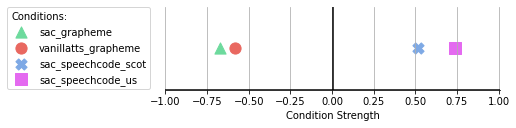

In [259]:
fig, ax = plt.subplots()
# ax.scatter(x=islr_res, y=np.array([0,0,0,0]))
markers = ['^', 'o','X', 's',]
colours = ['#6dda9d', '#e96860', '#7ea9e5', '#e46af0']
for (x_val, label), marker, colour in zip(sorted(zip(islr_res, column_names), reverse=False), markers, colours):
    ax.scatter(x=x_val, y=[0.125], marker=marker, label=label, s=125, c=colour)
    
ax.set_aspect(2)
ax.grid(True, which='both', axis="x")

#############################################
# set the x-spine (see below for more info on `set_position`)
# ax.spines['left'].set_position('zero')
# turn off the right spine/ticks

ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
# ax.yaxis.tick_left()

#############################################
# set the y-spine
ax.spines['bottom'].set_position('zero')

#############################################
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

ax.set_yticks([])

#############################################
# limits
plt.xlim([-1, 1.01])
plt.ylim([0, 0.25])

ax.axvline(x=0.0035, color='k')
ax.axhline(y=-0, color='k')

legend = ax.legend(
    # loc="upper left", 
    bbox_to_anchor =(-0.03, 1.05),
)

legend.set_title("Conditions:")
# legend.set_title(r"$\bf{Conditions}$")
                 # prop = {'size':15})
legend._legend_box.align = "left"

ax.set_xlabel("Condition Strength")
plt.savefig('plots/results.pdf', bbox_inches='tight')